# Librispeech Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

In [1]:
full_dataset_samplecount = 28539
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_samplecount * 100, 2)}%")

500 of total: 1.75%
1000 of total: 3.5%
2000 of total: 7.01%
4000 of total: 14.02%
8000 of total: 28.03%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
compression_palette = sns.color_palette("Spectral",3)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "librispeech-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/final-logs/librispeech/compression"
path_to_cum_df = f"{home_path}/librispeech-compression-GZIP-none-ZLIB-storage-ceph-hdd_2021-09-29-21:55:57_cum-df_samples-28539_threads-8-5-runs.csv"
path_to_cum_dstat_df = f"{home_path}/librispeech-compression-GZIP-none-ZLIB-storage-ceph-hdd_2021-09-29-21:55:57_cum-dstat-df_samples-28539_threads-8-5-runs.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["decoded", "spectrogram-\nencoded"]
print(strategies)

['2-read-and-decode-flac', '3-convert-to-spectrogram']


In [4]:
cum_df

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
0,2167.453613,8,8,9443.146484,28539,615.271240,46.384422,0,1,e60440,2-read-and-decode-flac,2021-09-29-21:55:57,GZIP,ceph-hdd
26,1773.767456,8,8,9467.679688,28539,619.366272,46.077740,0,1,d2c4e1,2-read-and-decode-flac,2021-09-30-08:15:24,ZLIB,ceph-hdd
24,1886.937866,8,8,9398.657227,28539,616.822693,46.267754,0,1,6a78bf,2-read-and-decode-flac,2021-09-30-04:28:37,ZLIB,ceph-hdd
22,2102.957764,8,8,9425.529297,28539,617.598633,46.209625,0,1,115b23,2-read-and-decode-flac,2021-09-30-00:34:50,ZLIB,ceph-hdd
20,2086.071289,8,8,9417.448242,28539,612.349609,46.605732,0,1,2c06e7,2-read-and-decode-flac,2021-09-29-20:35:11,ZLIB,ceph-hdd
18,2120.827881,8,8,11540.730469,28539,614.640930,46.431988,0,1,b74694,2-read-and-decode-flac,2021-09-30-10:49:48,none,ceph-hdd
16,1879.583618,8,8,11592.671875,28539,611.371277,46.680309,0,1,99e6ea,2-read-and-decode-flac,2021-09-30-07:01:36,none,ceph-hdd
28,1902.762817,8,8,9405.026367,28539,620.439636,45.998032,0,1,15274a,2-read-and-decode-flac,2021-09-30-12:13:37,ZLIB,ceph-hdd
12,1942.128540,8,8,11563.705078,28539,610.146973,46.773975,0,1,fabab5,2-read-and-decode-flac,2021-09-29-23:18:28,none,ceph-hdd
10,1757.305786,8,8,11541.154297,28539,599.627808,47.594524,0,1,46b134,2-read-and-decode-flac,2021-09-29-19:20:07,none,ceph-hdd


In [5]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write,compression_type,storage_type
0,0.0,1.690036,1.728357,0.000000,0.000000,0,28539,8,8,e60440,...,0.00,0.00,1440.0,14029.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
1,1.0,42.205185,0.000000,1.654953,0.023742,0,28539,8,8,e60440,...,0.03,0.01,1472.0,14061.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
2,2.0,0.000000,0.000000,2.069704,0.025928,0,28539,8,8,e60440,...,0.00,0.00,1472.0,14072.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
3,3.0,0.000000,0.000000,3.317325,0.035445,0,28539,8,8,e60440,...,0.00,0.00,1472.0,14085.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd
4,4.0,0.266240,0.114688,3.553081,0.039549,0,28539,8,8,e60440,...,0.00,0.00,1472.0,14105.0,3.0,2.0,0.0,5.0,GZIP,ceph-hdd


## 0. Experiment Information

### 0.1 Experiment Count

We want to profile each strategy with each compression at least 5 times. 

In [6]:
experiment_count_dict = {
    "split_name": []
  , "compression_type": []
  , "count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(split_name, compression_type, count):
    '''Short helper'''
    experiment_count_dict["split_name"] += [split_name]
    experiment_count_dict["compression_type"] += [compression_type]
    experiment_count_dict["count"] += [count]

for split_name in cum_df["split_name"].unique():
    for compression in cum_df["compression_type"].unique():
        experiment_count = get_experiment_count(cum_df.query(f"split_name=='{split_name}' and compression_type=='{compression}'"))
        add_to_dict(split_name, compression, experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,split_name,compression_type,count
0,2-read-and-decode-flac,GZIP,5
1,2-read-and-decode-flac,ZLIB,5
2,2-read-and-decode-flac,none,5
3,3-convert-to-spectrogram,GZIP,5
4,3-convert-to-spectrogram,ZLIB,5
5,3-convert-to-spectrogram,none,5


In [7]:
# order should be "none" -> "GZIP" -> "ZLIB"

cum_df_ord = cum_df.copy(deep=True)
order_dict = { "none": 10, "GZIP": 11, "ZLIB": 12 }
cum_df_ord = cum_df_ord.sort_values(by=["compression_type", "split_name"], key=lambda x: x.map(order_dict))
cum_df_ord

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
18,2120.827881,8,8,11540.730469,28539,614.640930,46.431988,0,1,b74694,2-read-and-decode-flac,2021-09-30-10:49:48,none,ceph-hdd
16,1879.583618,8,8,11592.671875,28539,611.371277,46.680309,0,1,99e6ea,2-read-and-decode-flac,2021-09-30-07:01:36,none,ceph-hdd
12,1942.128540,8,8,11563.705078,28539,610.146973,46.773975,0,1,fabab5,2-read-and-decode-flac,2021-09-29-23:18:28,none,ceph-hdd
10,1757.305786,8,8,11541.154297,28539,599.627808,47.594524,0,1,46b134,2-read-and-decode-flac,2021-09-29-19:20:07,none,ceph-hdd
14,1900.873901,8,8,11565.557617,28539,618.856628,46.115692,0,1,e8852f,2-read-and-decode-flac,2021-09-30-03:11:02,none,ceph-hdd
11,2100.344727,8,8,11547.451172,28539,19.312979,1477.710938,0,1,75f7dc,3-convert-to-spectrogram,2021-09-29-19:20:07,none,ceph-hdd
19,2244.334473,8,8,11558.520508,28539,21.425285,1332.024292,0,1,8bb989,3-convert-to-spectrogram,2021-09-30-10:49:48,none,ceph-hdd
17,1890.952881,8,8,11588.278320,28539,19.757179,1444.487549,0,1,f3c997,3-convert-to-spectrogram,2021-09-30-07:01:36,none,ceph-hdd
15,2087.056152,8,8,11570.178711,28539,21.010601,1358.314331,0,1,cebceb,3-convert-to-spectrogram,2021-09-30-03:11:02,none,ceph-hdd
13,1981.630981,8,8,11589.421875,28539,20.020727,1425.472778,0,1,1fea68,3-convert-to-spectrogram,2021-09-29-23:18:28,none,ceph-hdd


# 3. Compression
## 3.1 Compression Rate for each strategy

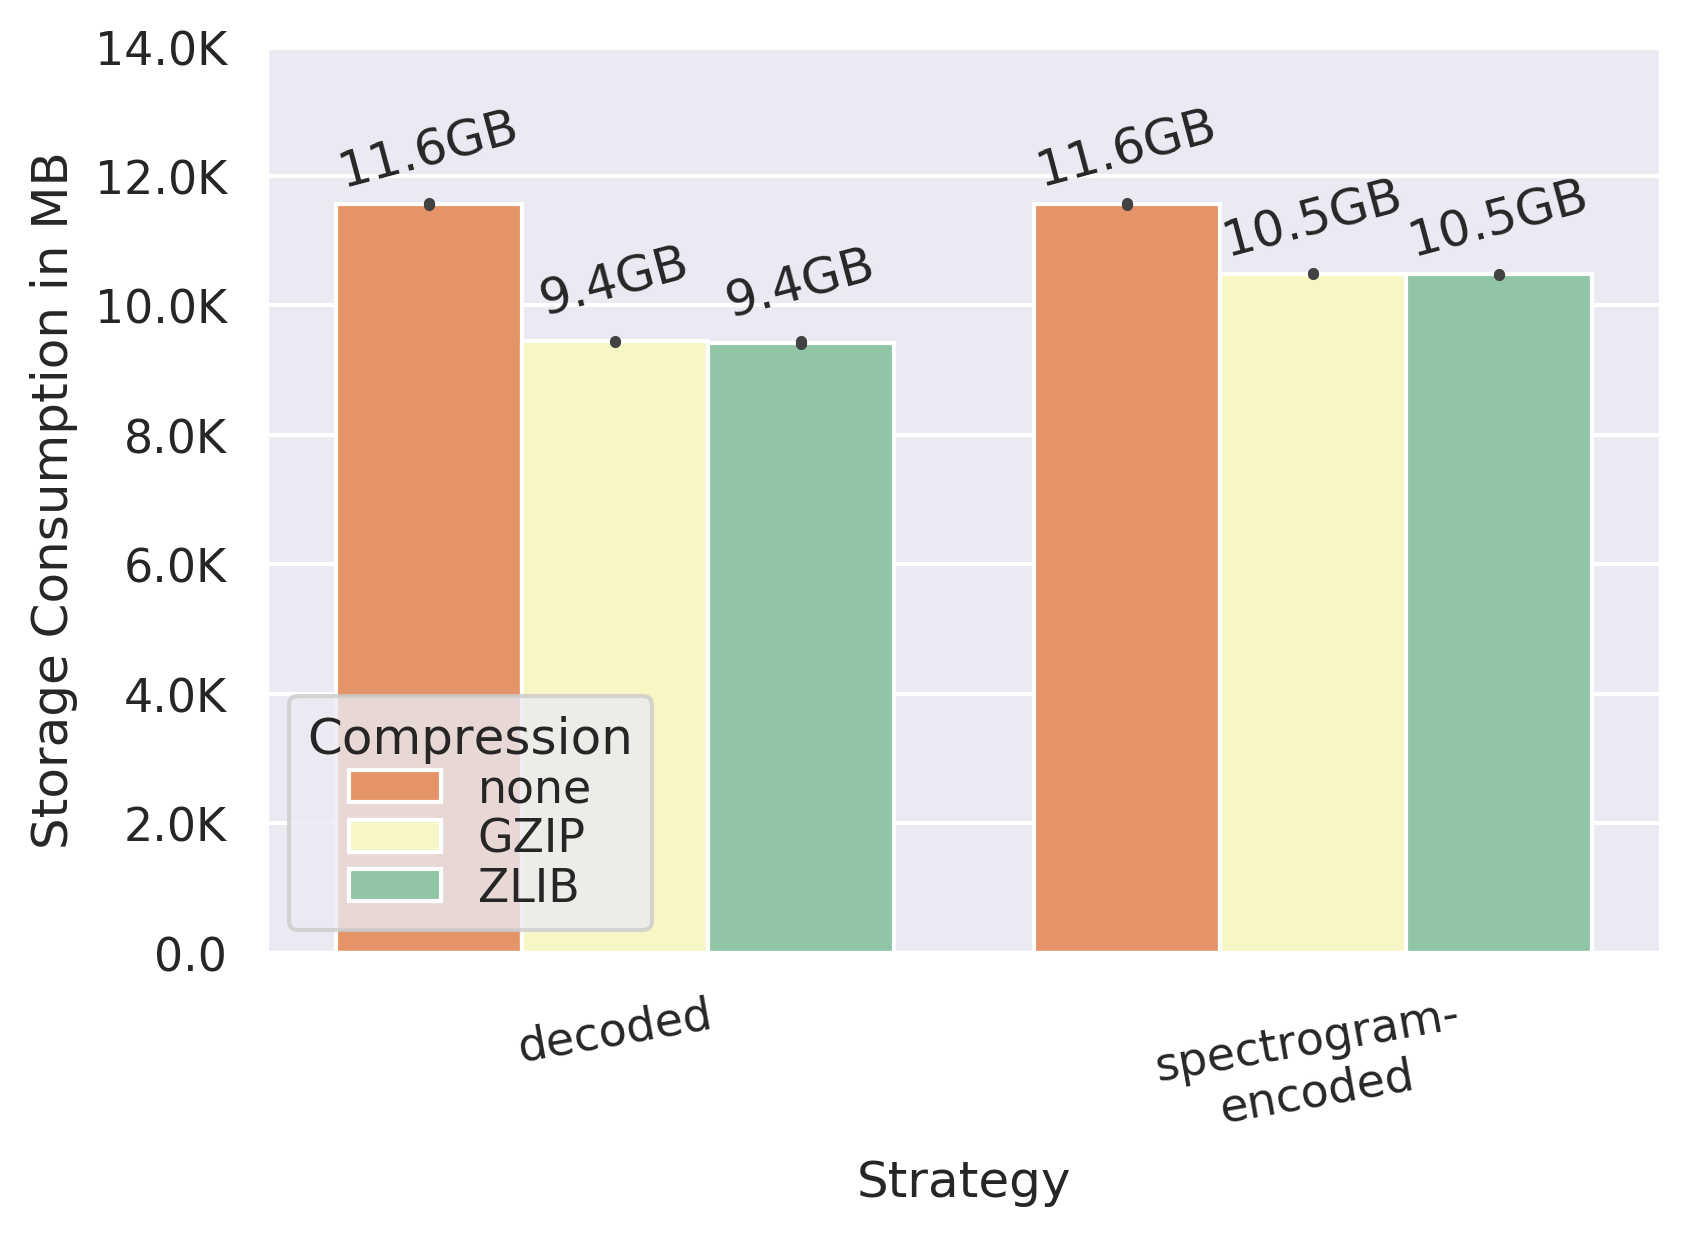

In [8]:
sns.set(palette=compression_palette)

cum_df_temp = cum_df_ord

plot = sns.barplot(
    x="split_name",
    y="shard_cum_size_MB",
    hue="compression_type",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(ylim=(0, 14000))
plot.set(xlabel="Strategy", ylabel="Storage Consumption in MB")
plot.legend(title="Compression", ncol=1, labelspacing=0.1, loc="lower left")
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=1000, rotation=15, storage_formatting=True)#, additional_space=[50000,-50000,0,-50000
                                                                                    #                     ,0,0,0,0
                                                                                    #                     ,-50000,-50000,-50000,-50000])

#save_fig("compressed-storage-consumption")

## 3.2 Storage and Throughput for each strategy

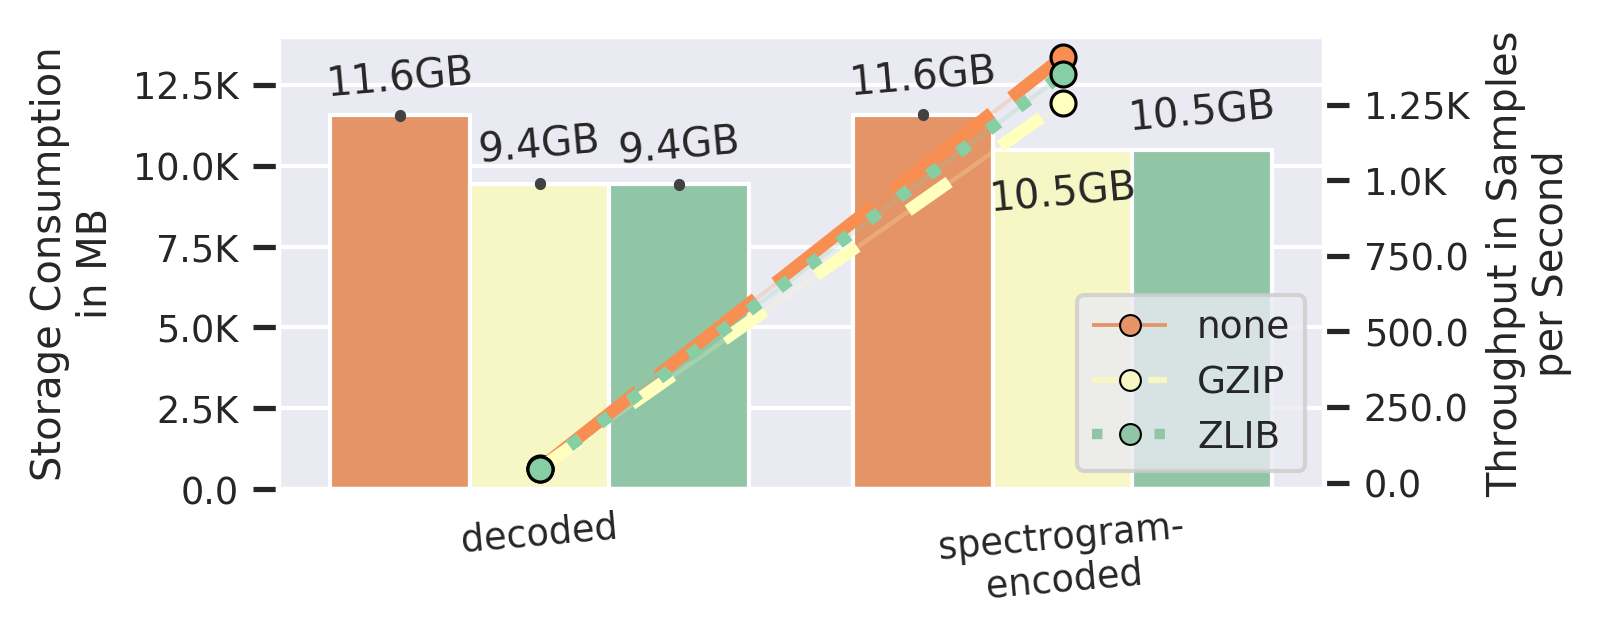

In [10]:
from matplotlib.lines import Line2D

sns.set(palette=compression_palette,font_scale=0.8)
marker = 'o'
linestyle = [(10,2), (4,5), (1,2)]
linestyle2 = [(0,(10,2)), (0,(4,5)), (0,(1,2))]

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.lineplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp,
    ax=ax2,
    size=3,
    sizes=(3,3),
    marker=marker,
    dashes=linestyle,
    ci=0.95,
    markeredgecolor='black',
    style='compression_type')

plot2.set(ylabel="Throughput in Samples\nper Second")
ax2.grid(False)
legend_elements = [
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=0.9, label='none', color="#E49467", linestyle=linestyle2[0]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=1.5, label='GZIP', color="#F7F7C6", linestyle=linestyle2[1]),
    Line2D([0], [0], marker=marker, markeredgecolor='#000000', markeredgewidth=0.5, markersize=5, lw=2.5, label='ZLIB', color="#90C6A6", linestyle=linestyle2[2])]
ax2.legend(handles=legend_elements, loc="lower right", prop={'size': 9})
#plot2.set(ylim=(0, 2300))        

plot = sns.barplot(
        x="split_name",
        y="shard_cum_size_MB",
        hue="compression_type",
        data=cum_df_temp,
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.yaxis.set_major_formatter(make_big_number_prettier)
show_values_on_bars(plot, h_v="v", space=1000, rotation=5, storage_formatting=True, additional_space=[0,0
                                                                                                     ,0,-2500
                                                                                                     ,0,0])
plot.set(ylim=(0, 14000))
ax1.get_legend().remove()
plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("compressed-storage-vs-throughput")

## 3.3 Throughput for each compression and each strategy

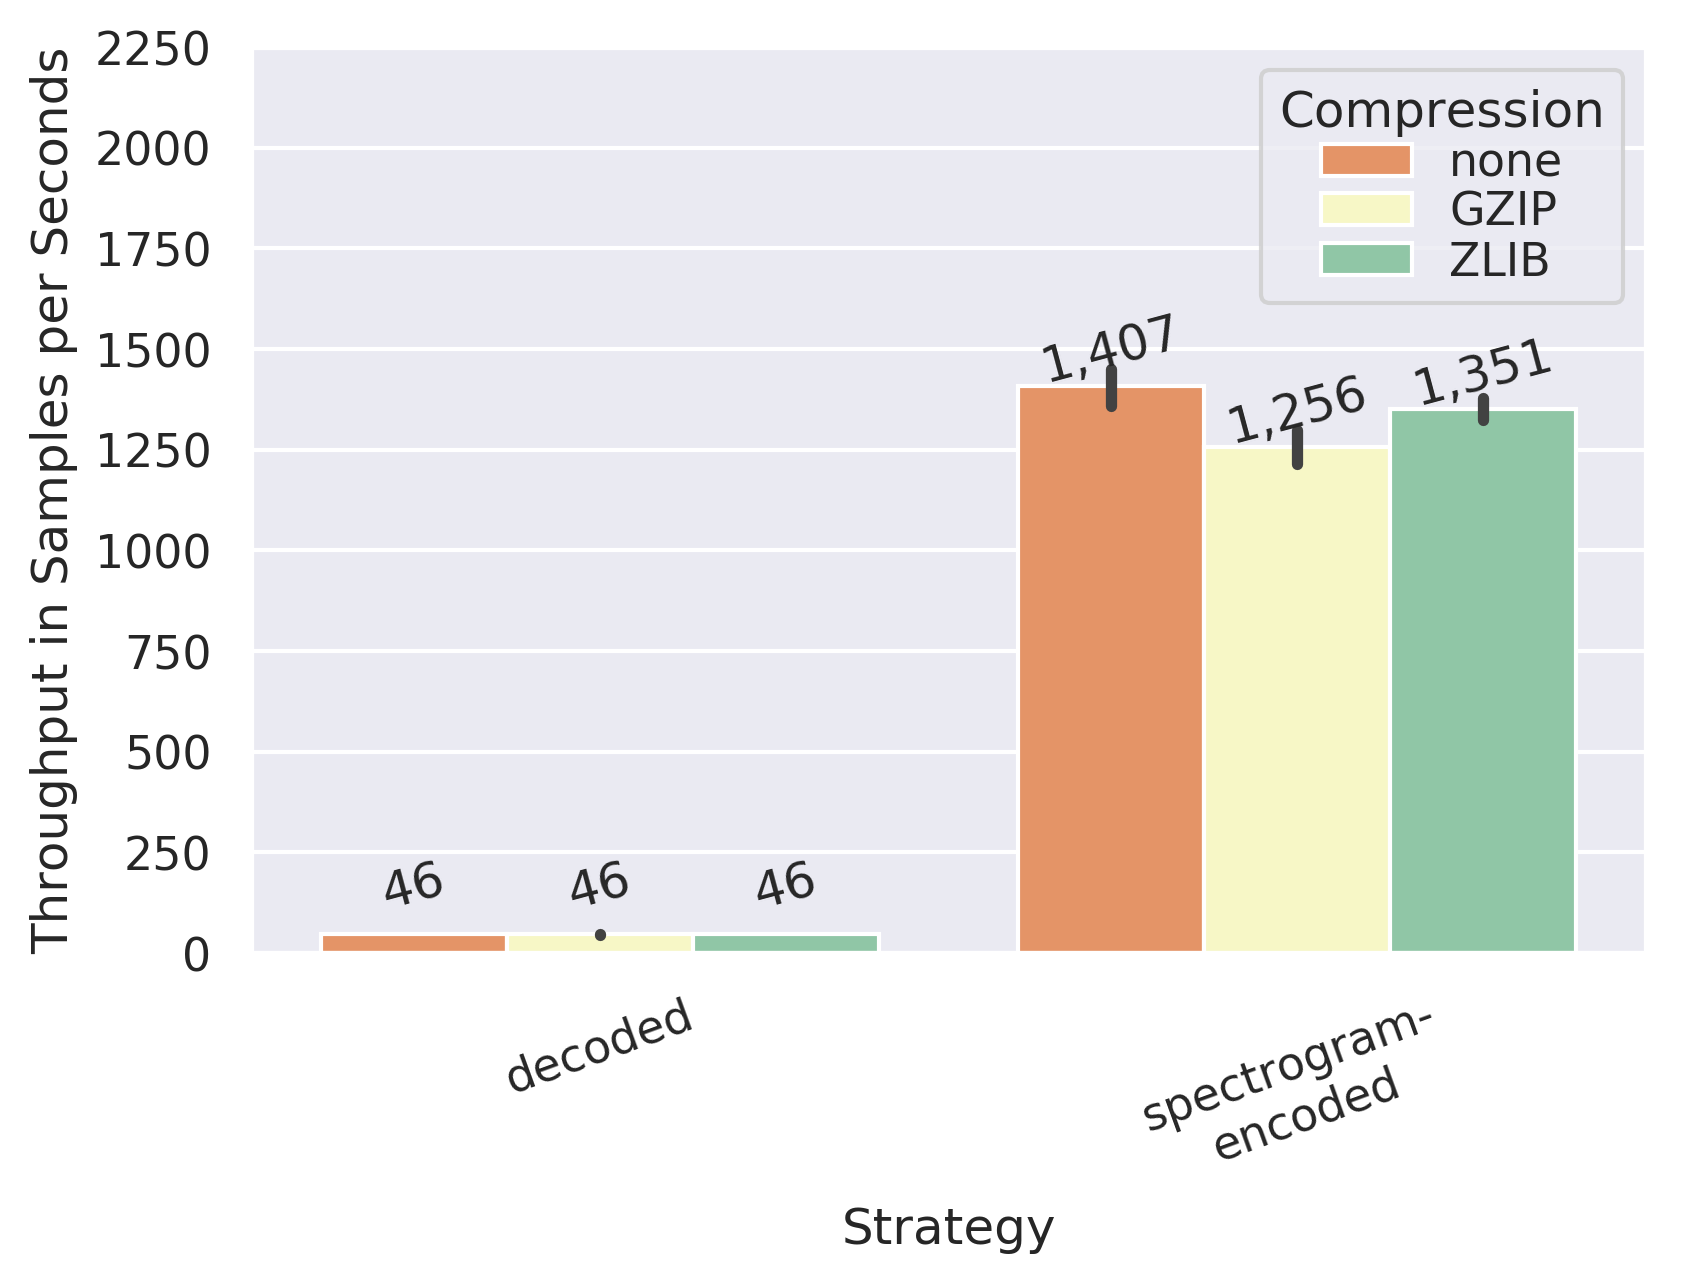

In [10]:
sns.set(palette=compression_palette)

cum_df_temp = cum_df_ord

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="compression_type",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 2250))
plot.legend(title="Compression", ncol=1, labelspacing=0.1)
show_values_on_bars(plot, h_v="v", space=100, rotation=15)
#save_fig("compression-throughput")

## 3.3 Full Dataset Processing Split

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [14]:
# calculate the per sample processing time for both offline and online processing
cum_df_ord["per_sample_online_processing_time_s"] = cum_df_ord["online_processing_time_s"] / cum_df_ord["sample_count"]
cum_df_ord["per_sample_offline_processing_and_save_time_s"] = cum_df_ord["offline_processing_and_save_time_s"] / cum_df_ord["sample_count"]
# calculate the total processing time for each sample count
cum_df_ord["total_processing_time_s"] = cum_df_ord["online_processing_time_s"] + cum_df_ord["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df_ord["full_dataset_online_processing_time_s"] = cum_df_ord["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_s"] = cum_df_ord["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df_ord["full_dataset_offline_processing_and_save_time_m"] = cum_df_ord["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df_ord["full_dataset_offline_processing_and_save_time_h"] = cum_df_ord["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df_ord["full_dataset_processing_time_s"] = cum_df_ord["full_dataset_online_processing_time_s"] + cum_df_ord["full_dataset_offline_processing_and_save_time_s"]
cum_df_ord["full_dataset_processing_time_m"] = cum_df_ord["full_dataset_processing_time_s"] / 60
cum_df_ord["full_dataset_processing_time_h"] = cum_df_ord["full_dataset_processing_time_m"] / 60 

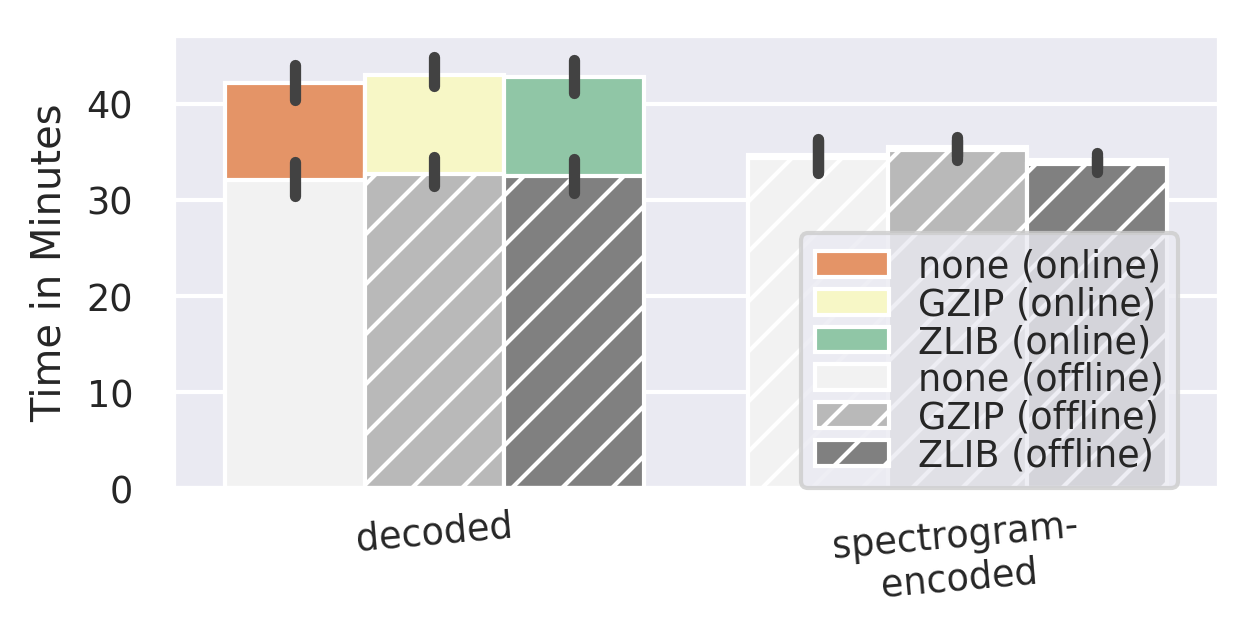

In [20]:
cum_df_temp = cum_df_ord
sns.set(palette=compression_palette, font_scale=0.8)
fig, ax1 = plt.subplots(figsize=(4.5,2))

plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_m",
    hue="compression_type",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_m",
    hue="compression_type",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=5
)
plot.tick_params(axis='x', which='major', pad=-1.5)
sample_counts = len(cum_df_temp.compression_type.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="", ylabel="Time in Minutes")
#plot.set(ylim=(0, 27))

handles, labels = plot.get_legend_handles_labels()

def add_status_to_handle(handle, index):
    compression_count = 3
    label = handle.get_label()
    if index >= compression_count:
        new_label = label + ' (offline)'
    else:
        new_label = label + ' (online)'
    handle.set_label(new_label)
    
for i, handle in enumerate(handles):
    add_status_to_handle(handle,index=i)

plot.legend(handles=handles, title="", loc=(0.6,0), ncol=1, labelspacing=0.02, columnspacing=0.3)
save_fig("compression-processing-time-split")

# X. Misc Plots and Calculations

## X.1 -

In [14]:
space_dict = {
    "strategy": []
   ,"space_saving_gzip": []
   ,"space_saving_zlib": []
   ,"sps_increase_gzip_fac": []
   ,"sps_increase_zlib_fac": []
}

def add_to_dict(strategy, ss_gzip, ss_zlib, sps_gzip, sps_zlib):
    space_dict["strategy"].append(strategy)
    space_dict["space_saving_gzip"].append(ss_gzip)
    space_dict["space_saving_zlib"].append(ss_zlib)
    space_dict["sps_increase_gzip_fac"].append(sps_gzip)
    space_dict["sps_increase_zlib_fac"].append(sps_zlib)
    
    
def space_saving(compressed, original):
    return round((1 - (compressed / original)) * 100, 2)

def throughput_increase(compressed, original):
    return round(compressed / original, 2)
    
for split_name in cum_df.split_name.unique():
    
    temp_df = cum_df.query(f"split_name=='{split_name}'")
    original_size = temp_df.query("compression_type=='none'").mean()["shard_cum_size_MB"]
    original_sps = temp_df.query("compression_type=='none'").mean()["throughput_sps"]
    gzip_size = temp_df.query("compression_type=='GZIP'").mean()["shard_cum_size_MB"]
    gzip_sps = temp_df.query("compression_type=='GZIP'").mean()["throughput_sps"]
    zlib_size = temp_df.query("compression_type=='ZLIB'").mean()["shard_cum_size_MB"]
    zlib_sps = temp_df.query("compression_type=='ZLIB'").mean()["throughput_sps"]

    print(f"Strategy: {split_name}")
    print(f"- Orig: {round(original_size, 2)}MB")
    print(f"- Orig: {round(original_sps, 2)}sps")
    print(f"- GZIP: {round(gzip_size, 2)}MB")
    print(f"- GZIP: {round(gzip_sps, 2)}sps")
    print(f"- ZLIB: {round(zlib_size, 2)}MB")    
    print(f"- ZLIB: {round(zlib_sps, 2)}sps")
    add_to_dict(strategy = split_name
               ,ss_gzip = space_saving(compressed = gzip_size, original = original_size)
               ,ss_zlib = space_saving(compressed = zlib_size, original = original_size)
               ,sps_gzip = throughput_increase(compressed = gzip_sps, original = original_sps)
               ,sps_zlib = throughput_increase(compressed = zlib_sps, original = original_sps))
    
pd.DataFrame(space_dict)    

Strategy: 2-read-and-decode-flac
- Orig: 11560.76MB
- Orig: 46.72sps
- GZIP: 9446.13MB
- GZIP: 46.1sps
- ZLIB: 9422.87MB
- ZLIB: 46.23sps
Strategy: 3-convert-to-spectrogram
- Orig: 11570.77MB
- Orig: 1407.6sps
- GZIP: 10490.14MB
- GZIP: 1256.58sps
- ZLIB: 10484.1MB
- ZLIB: 1351.08sps


,strategy,space_saving_gzip,space_saving_zlib,sps_increase_gzip_fac,sps_increase_zlib_fac
0,2-read-and-decode-flac,18.29,18.49,0.99,0.99
1,3-convert-to-spectrogram,9.34,9.39,0.89,0.96


## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [104]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['2-read-image', '3-decode-image', '4-resize-image', '5-center-pixel-values']

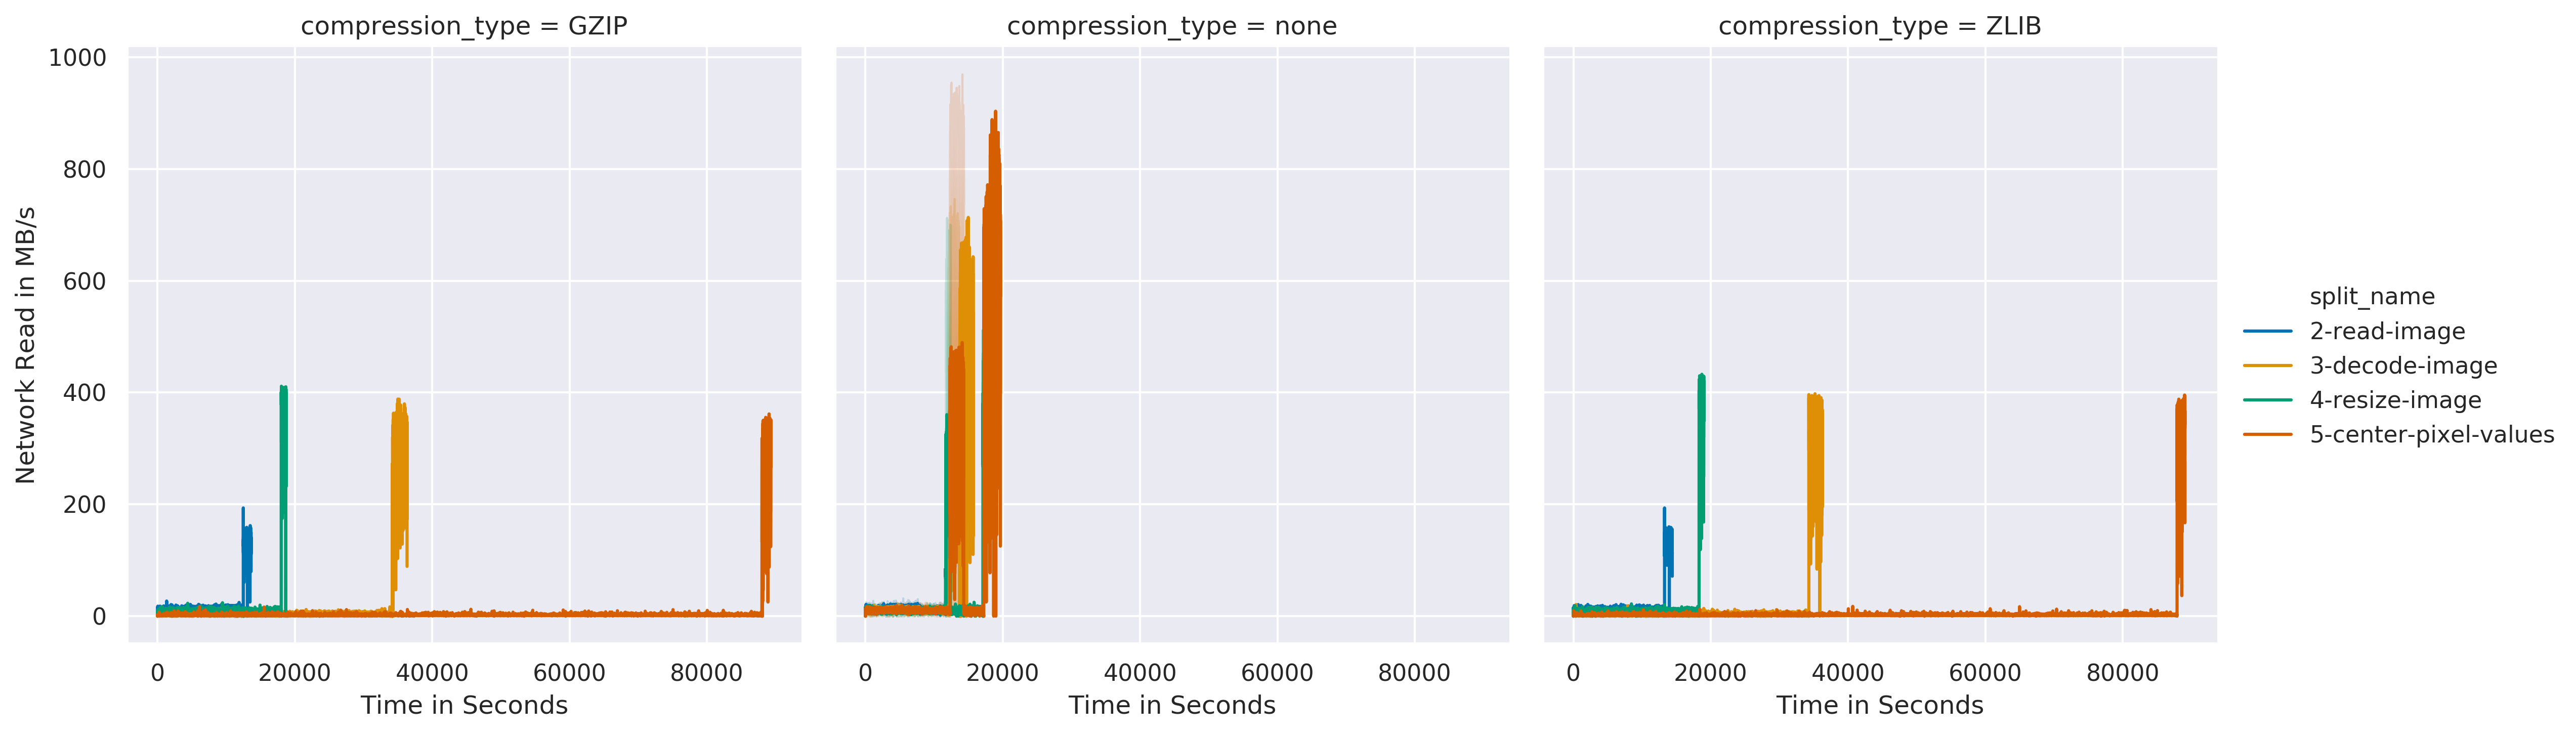

In [105]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    col="compression_type",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

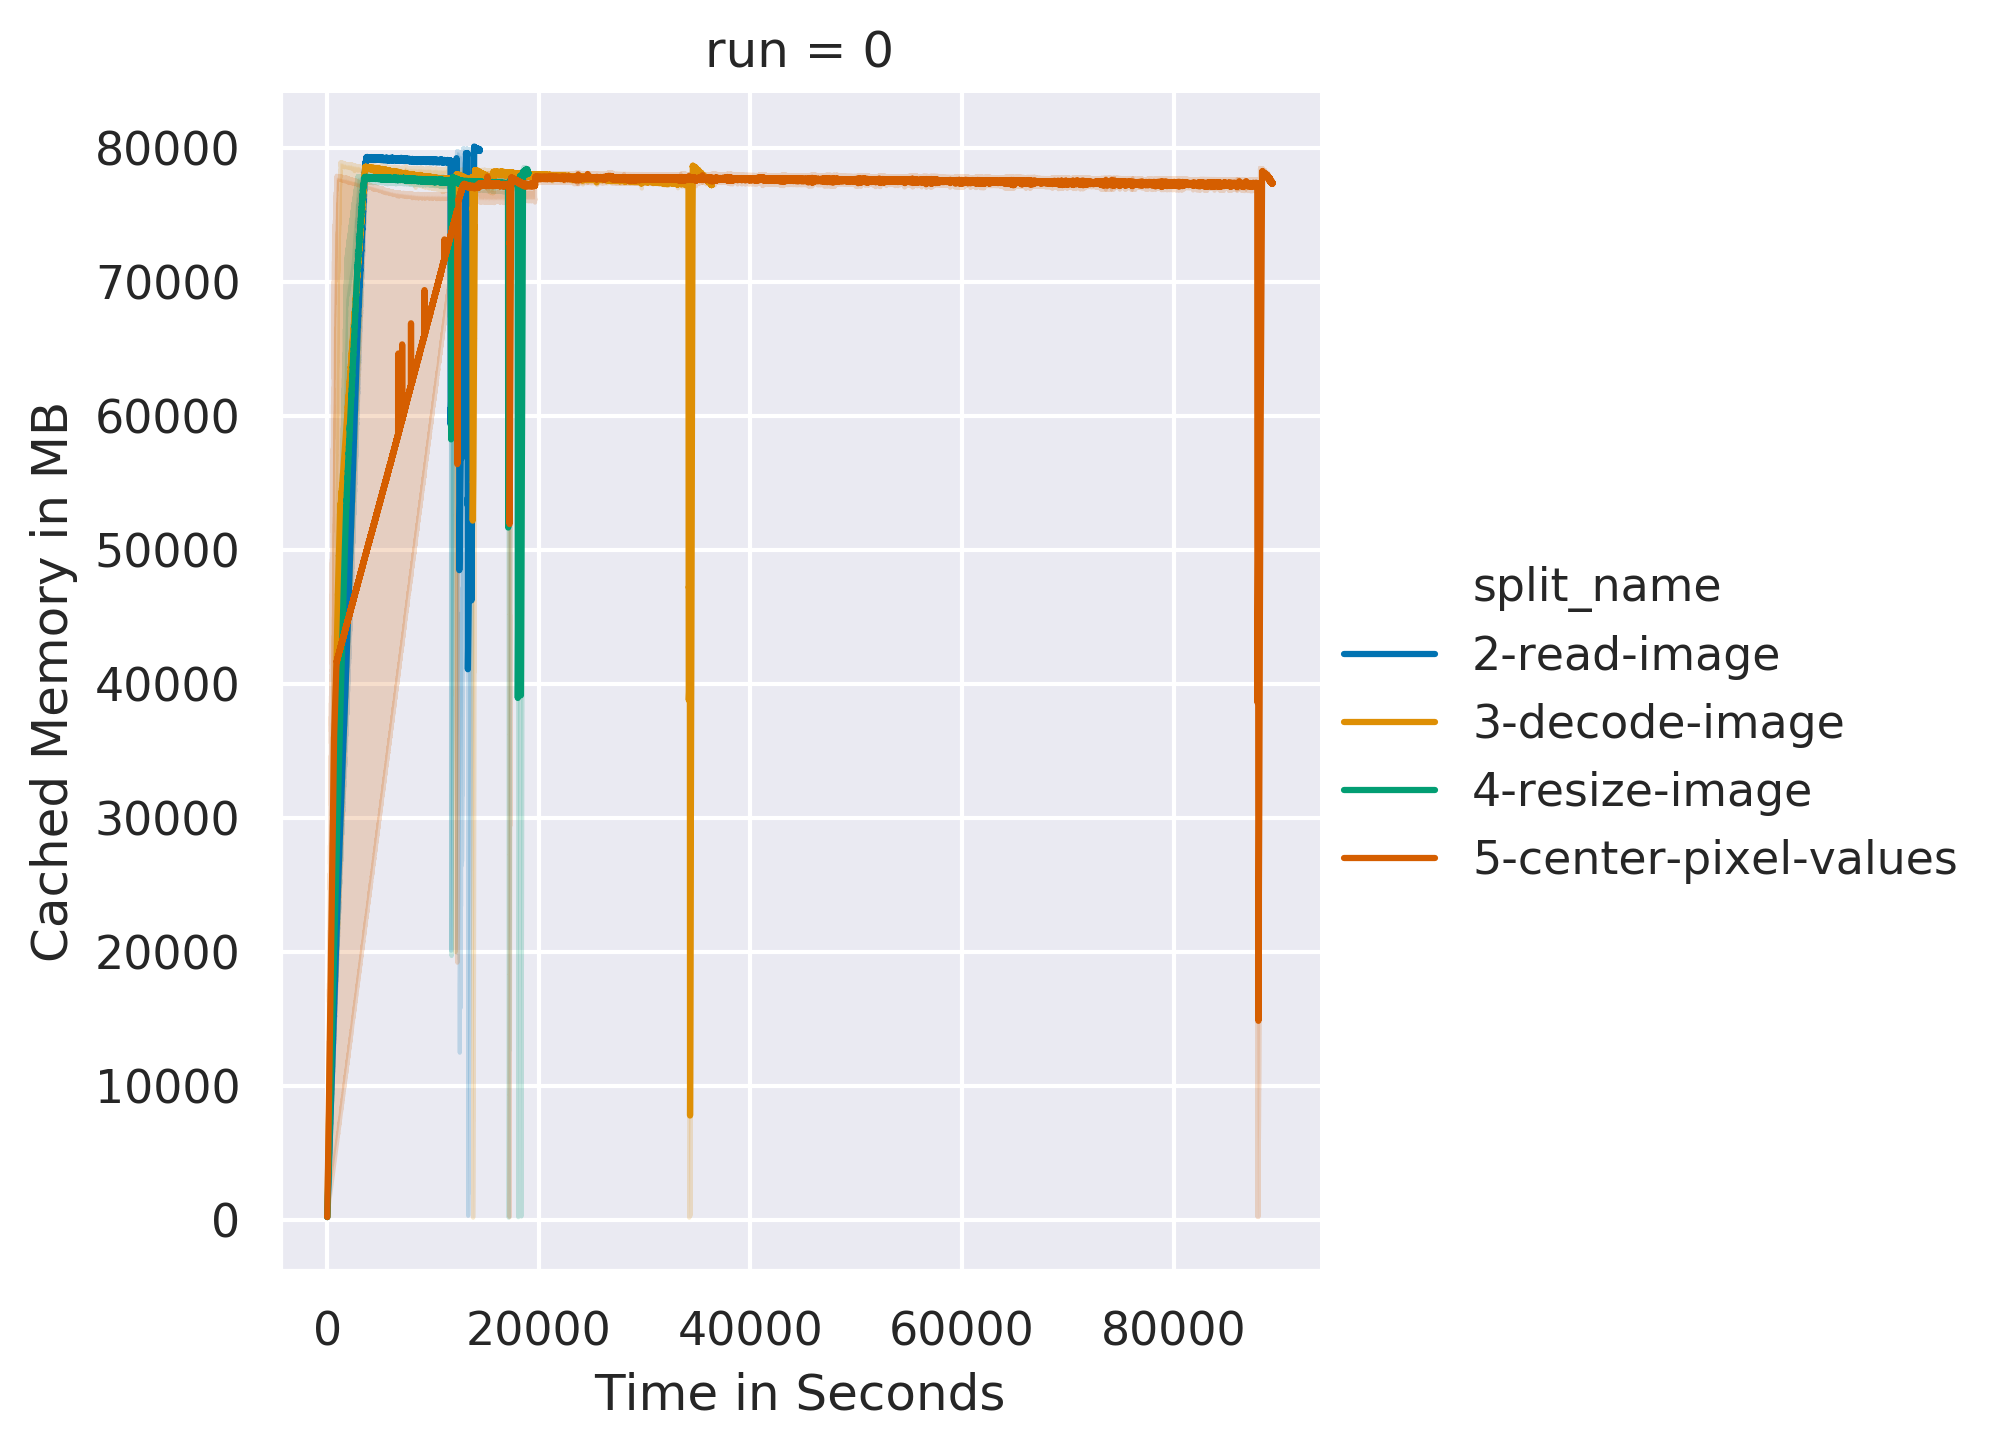

In [106]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy

plot = sns.relplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")